In [1]:
#basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/DJIA_table.csv')

In [4]:
df['DiffPrice'] = df['Close']-df['Open']

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,DiffPrice
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,25.128907
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,217.230468
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,238.660157
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,219.210937
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-214.970704


In [6]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close,DiffPrice
count,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000
mean,13459.116048,13541.303173,13372.931728,13463.032255,1.628110e+08,13463.032255,3.916206
std,3143.281634,3136.271725,3150.420934,3144.006996,9.392343e+07,3144.006996,141.227938
min,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,6547.049805,-774.169922
25%,10907.339844,11000.980469,10824.759766,10913.379883,1.000000e+08,10913.379883,-60.169922
50%,13022.049805,13088.110352,12953.129883,13025.580078,1.351700e+08,13025.580078,8.540039
75%,16477.699219,16550.070312,16392.769531,16478.410156,1.926000e+08,16478.410156,74.558594
max,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,18312.390625,925.190430


In [7]:
data = df
data = data.set_index('Date')
data = data.loc[:,'Close']

<AxesSubplot:xlabel='Date'>

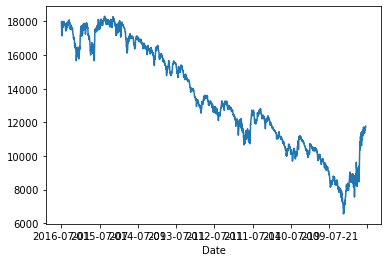

In [8]:
data.plot()

In [9]:
data.describe()

count     1989.000000
mean     13463.032255
std       3144.006996
min       6547.049805
25%      10913.379883
50%      13025.580078
75%      16478.410156
max      18312.390625
Name: Close, dtype: float64

In [10]:
import matplotlib.pyplot as plt

In [11]:
#stationarity test
from statsmodels.tsa.stattools import adfuller

In [12]:
result = adfuller(data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -1.226757785411685
p-value: 0.6619805931301762


In [13]:
data_price_diff = df
data_price_diff = data_price_diff.set_index('Date')
data_price_diff =  data_price_diff.loc[:,'DiffPrice']

<AxesSubplot:xlabel='Date'>

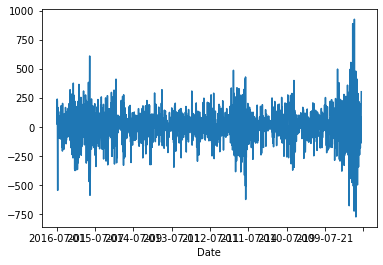

In [14]:
data_price_diff.plot()

In [15]:
result = adfuller(data_price_diff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -10.090028744927771
p-value: 1.1285560565967265e-17


In [25]:
from sklearn.preprocessing import MinMaxScaler
data.reshape(-1,1)
min_max_scaler = MinMaxScaler(feature_range=(0,1))
data = min_max_scaler.fit_transform(data)


AttributeError: 'Series' object has no attribute 'reshape'

In [16]:

#time-series prediction models
#from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#trend analysis
from sklearn.linear_model import LinearRegression

#to generate all combinations of the parameters
import itertools

#models' accuracy calculation
from sklearn.metrics import mean_squared_error

#to ignore all warnings
import warnings
warnings.filterwarnings('ignore')

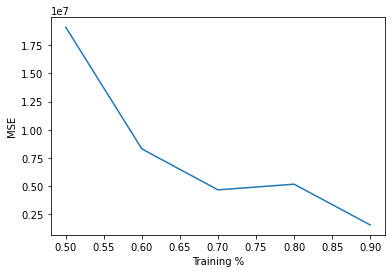

In [17]:
#plot the accuracy with various train-test splits

x = data.values

train_per_list=[0.5,0.6,0.7,0.8,0.9]
acc_list=[]

for train_per in train_per_list:
    
    #perform the split
    train = x[:int(x.size*train_per)]
    test = x[int(x.size*train_per):]
    
    #train the model
    arma_model = ARIMA(train, order=(1, 0, 1))
    arma_fit = arma_model.fit()
    arma_pred = arma_fit.predict(start=int(x.size*train_per), end=x.size-1)
    
    #store the results
    acc_list.append(mean_squared_error(test, arma_pred))

#plot the graph
plt.plot(train_per_list,acc_list)
plt.ylabel('MSE')
plt.xlabel('Training %')
plt.show()

In [20]:
x = data.values
#take all variants of P,D,Q from 0 to 5 (integers)
#p=d=q = range(0,5)
p = range(1,5)
q=d=range(0,5)
pdq = list(itertools.product(p,d,q))

acc_list = []
best = []
smallest_mse = 1000000000000000
i=1
for param in pdq:

    
    i+=1
    
    try:
        #train the model 
        arima_model = ARIMA(train, order=param)
        arima_fit = arima_model.fit()
        
        #record the predictions for calculating accuracy
        arima_pred = arima_fit.predict(start=int(x.size*train_per), end=x.size-1)
        acc=mean_squared_error(test, arima_pred)
        
        #store the accrucy in a list for graph plotting
        acc_list.append(acc)
        
        #capture the smallest MSE and its parameters
        if acc < smallest_mse:
            smallest_mse = acc
            best = param
        print("Executing : ",i,"/",len(pdq)," : ", param, "MSE ",acc)    

    except:
        #if the parameters are invalid, i.e. model training gives error, 
        #then add a very high error rate in the accrucy list
        acc_list.append(100000)
        continue
        
print("\n\nsmallest mse is ", smallest_mse)
print("best parameters are ", best)

Executing :  2 / 100  :  (1, 0, 0) MSE  1529804.1522390824
Executing :  3 / 100  :  (1, 0, 1) MSE  1559411.0697387706
Executing :  4 / 100  :  (1, 0, 2) MSE  1546575.5792151815
Executing :  5 / 100  :  (1, 0, 3) MSE  1575768.372290718
Executing :  6 / 100  :  (1, 0, 4) MSE  1593383.5576445065
Executing :  7 / 100  :  (1, 1, 0) MSE  79903985.06585151
Executing :  8 / 100  :  (1, 1, 1) MSE  79903886.2865925
Executing :  9 / 100  :  (1, 1, 2) MSE  79903937.78122318
Executing :  10 / 100  :  (1, 1, 3) MSE  79875238.44757137
Executing :  11 / 100  :  (1, 1, 4) MSE  79900889.23169291
Executing :  12 / 100  :  (1, 2, 0) MSE  79816247.46008363
Executing :  13 / 100  :  (1, 2, 1) MSE  79825131.27715929
Executing :  14 / 100  :  (1, 2, 2) MSE  79825146.59756914
Executing :  15 / 100  :  (1, 2, 3) MSE  79825148.02801247
Executing :  16 / 100  :  (1, 2, 4) MSE  79825150.42618318
Executing :  27 / 100  :  (2, 0, 0) MSE  1921291.8560990694
Executing :  28 / 100  :  (2, 0, 1) MSE  1547764.1574994074
